# Louis Long Notebook

### Emil studid & Louis studid, teamname 

#### Table of contents:
1. Exploratory data analysis
2. Models/Predictors
    - Model 1
    - Model 2
    - model ...
3. Feature Engineering 
    - Lime
    - feature importance
    - PDP
4. Model Interpretations
5. Improved models (possibly)



# ___________ _0. Setup_ ___________

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn.metrics as metrics
import sklearn.ensemble as ensemble
import optuna
import lightgbm as lgb
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold, cross_val_score
from sklearn.metrics import log_loss, mean_squared_error, mean_squared_log_error
from verstack import LGBMTuner, MeanTargetEncoder, OneHotEncoder


#from pandas_profiling import ProfileReport

/Users/louislinnerud/Documents/skole/3.klasse/5.semester/MachineLearning/CodeFolder2/MachineLearning-TDT4173-Project/MLvenv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def writeResultToFile(test_data, pred_data, nameOfFile='namelessSubmission'):
    submission = pd.DataFrame()
    submission['id'] = test_data['store_id']
    submission['predicted'] = np.asarray(pred_data)
    submission.to_csv('submissionFiles/'+ nameOfFile+'.csv', index=False)
    

In [3]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5

# ___________ _1. Exploratory Data Analysis_ ___________


### EDA Notes
- [ ] Search domain knowledge
- [ ] Check if the data is intuitive
- [ ] Understand how the data was generated
- [ ] Explore individual features
    - [x] Agencies
    - [x] stores with 0 revenue
    - [x] food and drink stores and grovery stores
- [ ] Explore pairs and groups
    - [x] Store type vs revenue
- [ ] Clean up features
    - [x] remove 2016
    - [x] remove outliers
    - [x] remove 0 revenue rows


In [4]:
stores_train = pd.read_csv('data/stores_train.csv')


In [5]:
stores_train.head()

store_id  year                           store_name  \
0   983540538-974187930-44774  2016  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755  2016           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491  2016                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912  2016        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469  2016             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

In [6]:
stores_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12859 entries, 0 to 12858
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   store_id             12859 non-null  object 
 1   year                 12859 non-null  int64  
 2   store_name           12859 non-null  object 
 3   plaace_hierarchy_id  12859 non-null  object 
 4   sales_channel_name   12859 non-null  object 
 5   grunnkrets_id        12859 non-null  int64  
 6   address              11085 non-null  object 
 7   lat                  12859 non-null  float64
 8   lon                  12859 non-null  float64
 9   chain_name           3737 non-null   object 
 10  mall_name            2280 non-null   object 
 11  revenue              12859 non-null  float64
dtypes: float64(3), int64(2), object(7)
memory usage: 1.2+ MB


In [7]:
stores_train.describe()

year  grunnkrets_id           lat           lon       revenue
count  12859.0   1.285900e+04  12859.000000  12859.000000  12859.000000
mean    2016.0   9.338697e+06     61.212166      9.995425      8.220683
std        0.0   5.788875e+06      2.965672      3.793565     15.377130
min     2016.0   1.010105e+06     57.994443      4.625889      0.000000
25%     2016.0   3.014208e+06     59.421935      7.284691      1.195000
50%     2016.0   9.065213e+06     59.939017     10.407916      3.374000
75%     2016.0   1.449011e+07     62.116531     10.848180      7.996000
max     2016.0   2.030031e+07     71.098287     31.118935    219.599000

In [8]:
#report = ProfileReport(stores_train)
#report

Explore revenue based on store type

In [9]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')

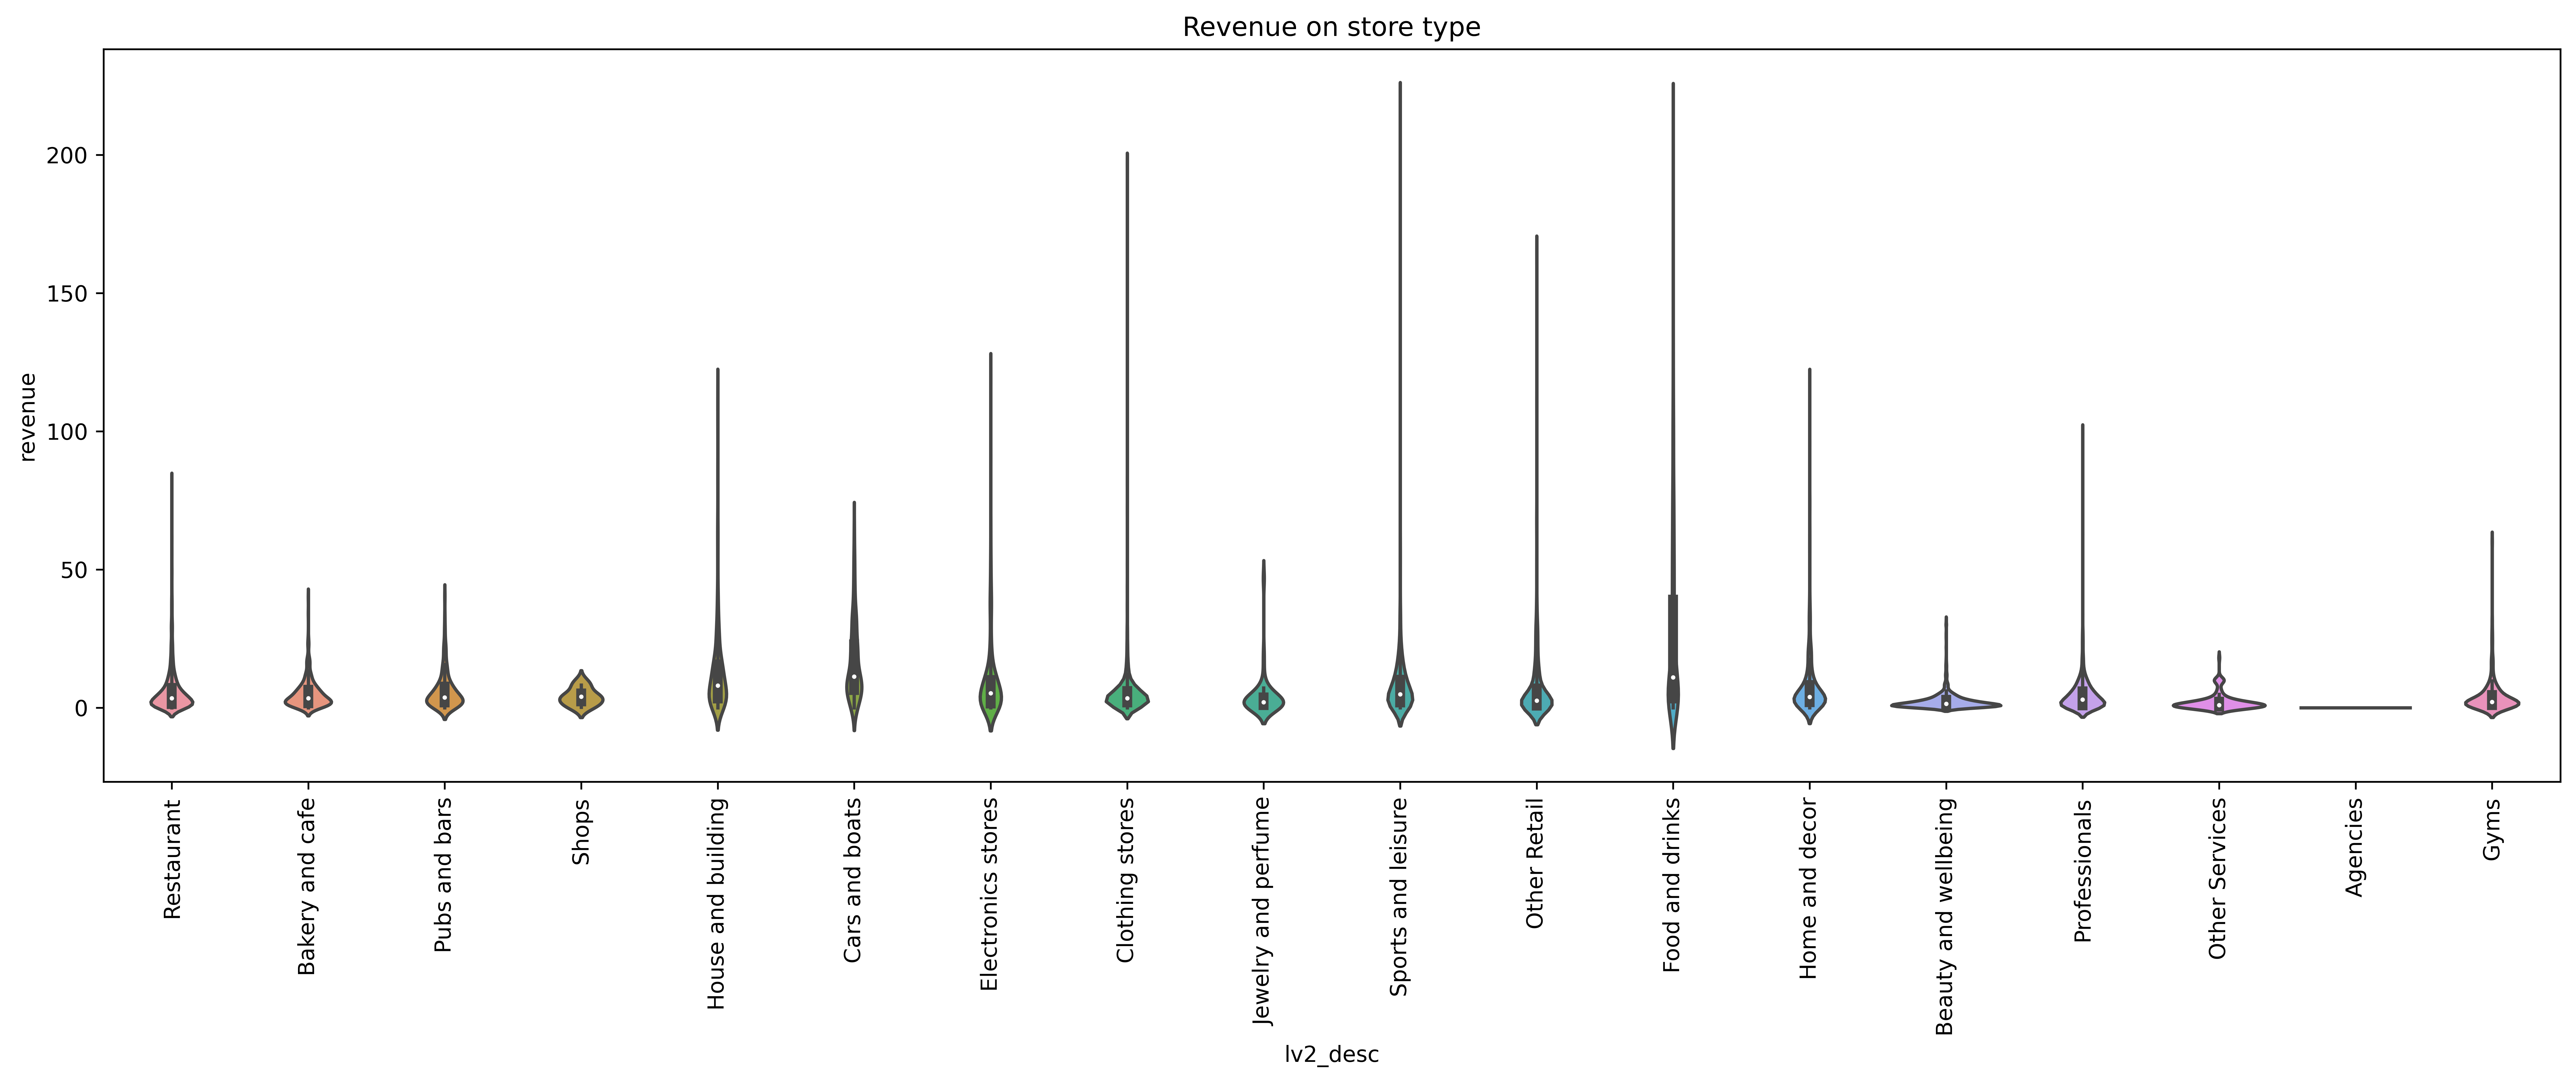

In [10]:
plt.figure(figsize=(20,6))
plt.gcf().set_dpi(600)
plt.xticks(rotation=90)
sns.violinplot(x='lv2_desc',y='revenue',data=stores_with_hierarchy).set_title("Revenue on store type")
plt.show()

further exploration of agencie store type

In [11]:
stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Agencies"]

store_id  year                     store_name  \
12442  915797512-915815782-782390  2016  RUUKKI BUILDING COMPONENTS AS   

      plaace_hierarchy_id  sales_channel_name_x  grunnkrets_id  \
12442             3.5.3.0  Advertising agencies        3014005   

                  address        lat        lon chain_name  ... revenue  \
12442  ØSTRE AKER VEI 219  59.948112  10.883745        NaN  ...     0.0   

       sales_channel_name_y lv1  lv1_desc  lv2  lv2_desc    lv3  \
12442  Advertising agencies   3  Services  3.5  Agencies  3.5.3   

                   lv3_desc      lv4              lv4_desc  
12442  Advertising agencies  3.5.3.0  Advertising agencies  

[1 rows x 21 columns]

Further exploration of "Food and drink" type stores


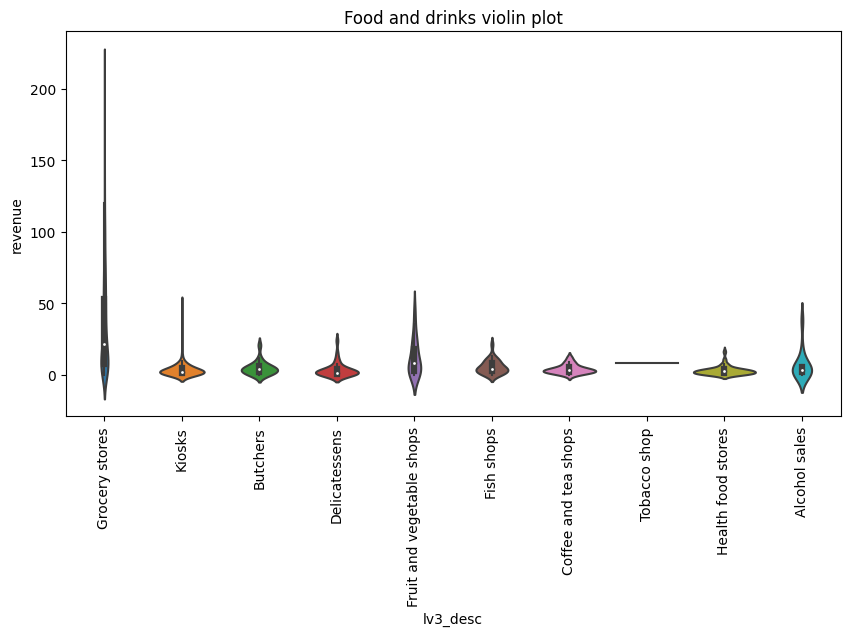

In [12]:
plt.figure(figsize=(10,5))
sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]=="Food and drinks"]).set_title("Food and drinks violin plot")
plt.xticks(rotation=90)
plt.show()

Explore retailers with 0 revenue

In [13]:
stores_with_hierarchy[stores_with_hierarchy["revenue"]==0.0].describe()

year  grunnkrets_id         lat         lon  revenue         lv1  \
count   217.0   2.170000e+02  217.000000  217.000000    217.0  217.000000   
mean   2016.0   7.609318e+06   60.671650   10.007769      0.0    1.788018   
std       0.0   5.511516e+06    2.432534    3.006842      0.0    0.594141   
min    2016.0   1.040301e+06   58.029041    5.035586      0.0    1.000000   
25%    2016.0   3.010401e+06   59.559941    8.591472      0.0    1.000000   
50%    2016.0   6.020802e+06   59.919065   10.620743      0.0    2.000000   
75%    2016.0   1.201012e+07   60.394286   10.814440      0.0    2.000000   
max    2016.0   2.030030e+07   69.890997   30.043801      0.0    3.000000   

              lv2  
count  217.000000  
mean     2.188940  
std      0.758634  
min      1.100000  
25%      1.100000  
50%      2.400000  
75%      2.800000  
max      3.600000

All retailers and their cooresponding revenue, the plot is to visually check for outliers, clearly there are som outliers as can be seen in the plot below

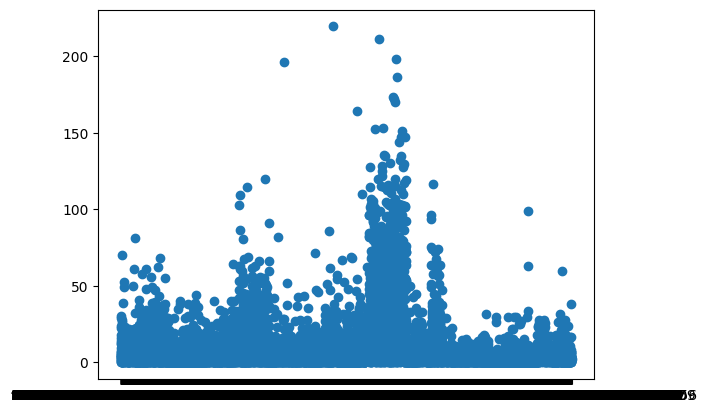

<Figure size 3000x500 with 0 Axes>

In [14]:
plt.plot(stores_train['store_id'], stores_train['revenue'],'o')
plt.figure(figsize=(30,5))
plt.show()

### Cleaning

#### Remove columns function - example: year is a const value and has no effect on the end result

In [15]:
def remove_columns(dataSet, columns):
    for column in columns:
        dataSet.drop(column, axis=1, inplace=True)


In [16]:
remove_columns(stores_train,['year'])
stores_train.head()

store_id                           store_name  \
0   983540538-974187930-44774  MCDONALD'S BRAGERNES TORG MAGASINET   
1   987074191-973117734-44755           MCDONALD'S KLINGENBERGGATA   
2   984890265-981157303-64491                 BURGER KING HØNEFOSS   
3  914057442-992924179-126912        BURGER KING GLASSHUSPASSASJEN   
4  913018583-913063538-668469             BURGER KING TILLERTORGET   

  plaace_hierarchy_id     sales_channel_name  grunnkrets_id  \
0             1.1.1.0  Hamburger restaurants        6020303   
1             1.1.1.0  Hamburger restaurants        3010306   
2             1.1.1.0  Hamburger restaurants        6050102   
3             1.1.1.0  Hamburger restaurants       18040102   
4             1.1.1.0  Hamburger restaurants       16017414   

             address        lat        lon   chain_name          mall_name  \
0  BRAGERNES TORG 13  59.743104  10.204928    MCDONALDS  Magasinet Drammen   
1                NaN  59.913759  10.734031    MCDONALDS                NaN   
2  KONG RINGS GATE 1  60.164751  10.254656  BURGER KING     Kuben Hønefoss   
3        STORGATA 12  67.283669  14.379796  BURGER KING  Glasshuspassasjen   
4                NaN  63.358068  10.374832  BURGER KING       Tillertorget   

   revenue  
0   17.998  
1   23.828  
2   16.099  
3    9.296  
4    4.528

#### Remove retailers with 0 revenue function - might be handy

In [17]:
def remove_retailers_with_0_revenue(dataSet):
    dataSet.drop(dataSet[dataSet['revenue']==0.0].index, inplace=True)

In [18]:
#remove_retailers_with_0_revenue(stores_train)

#### Removing outliers

Plotting all retailers based on storetype before and after trimming to confirm that outliers actually has been removed

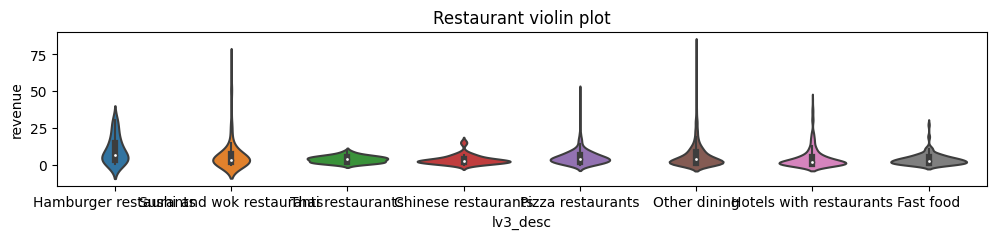

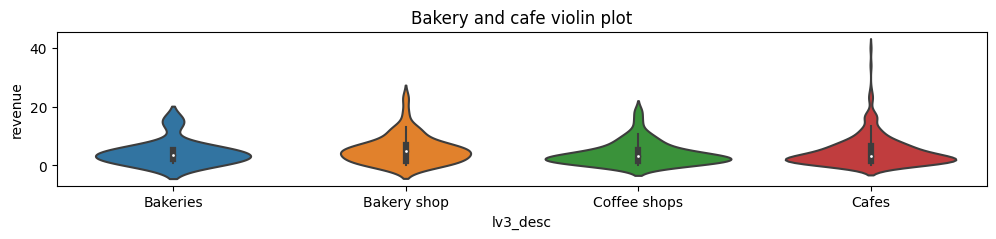

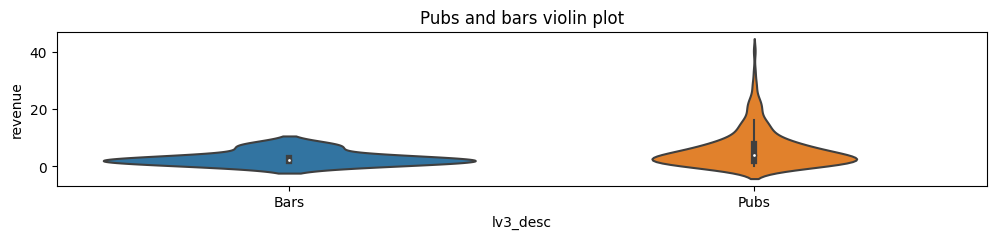

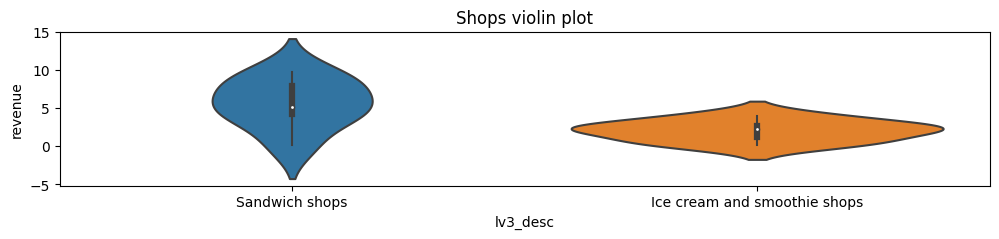

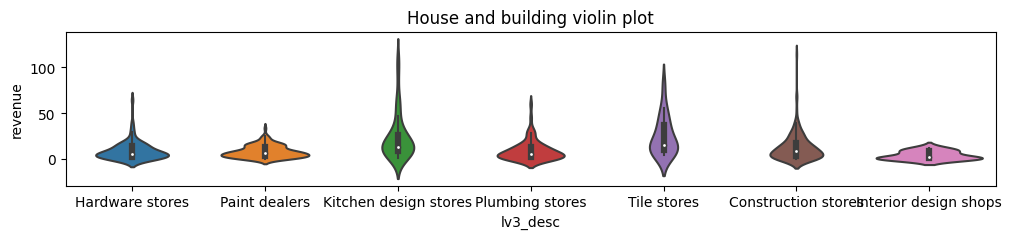

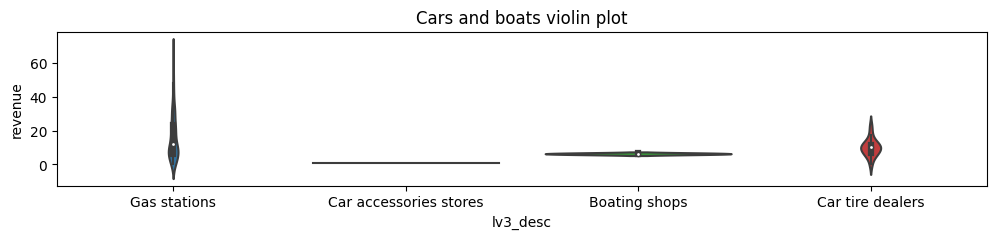

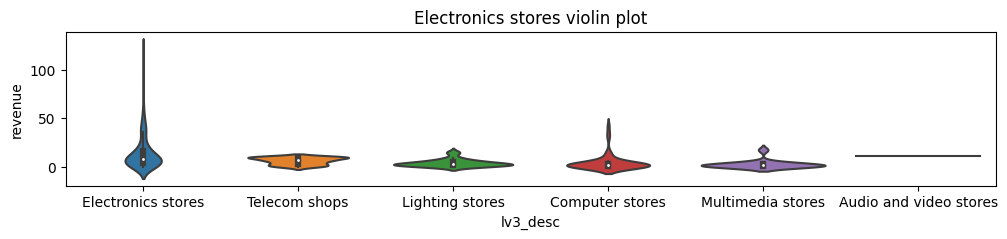

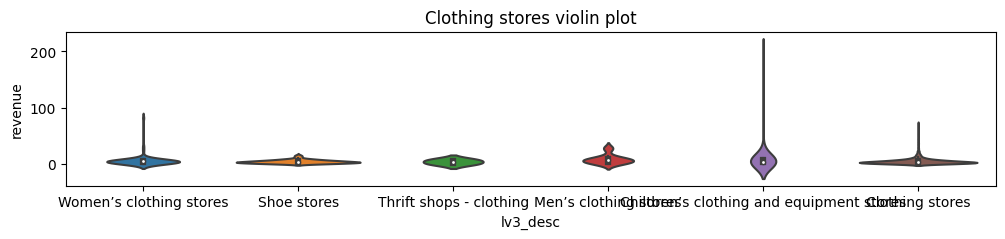

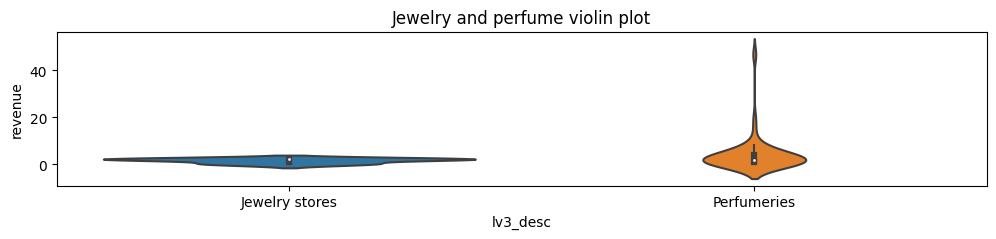

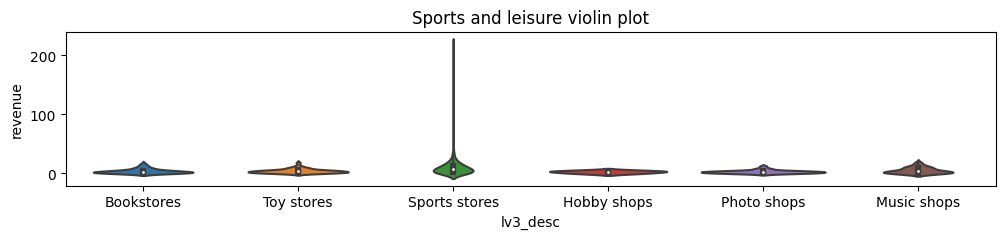

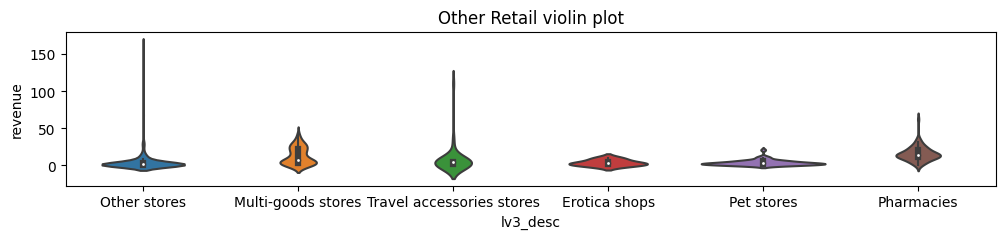

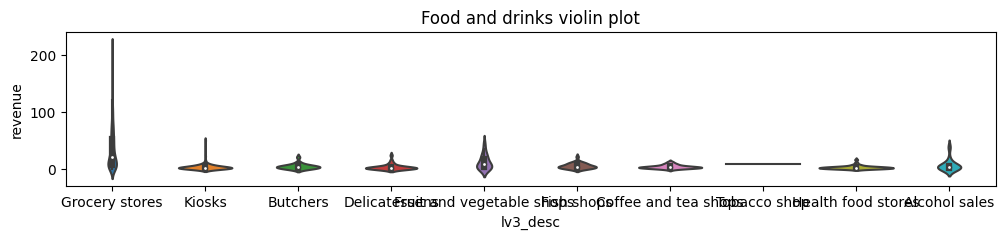

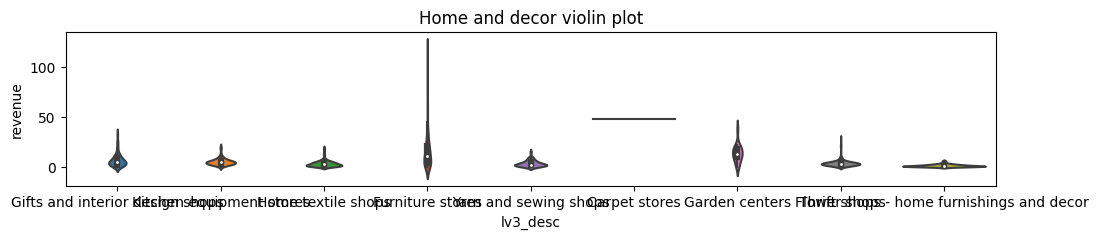

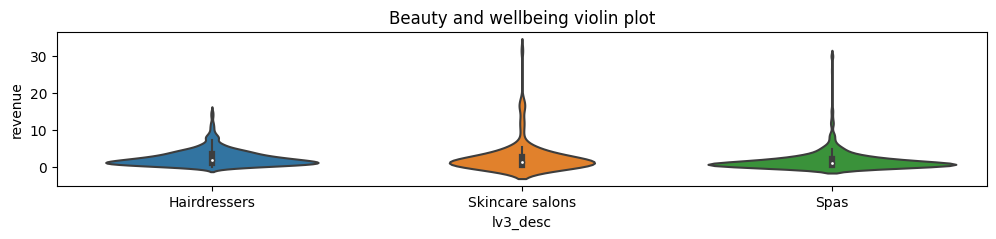

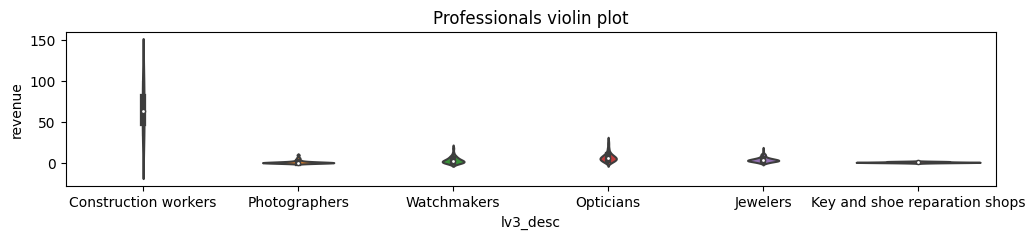

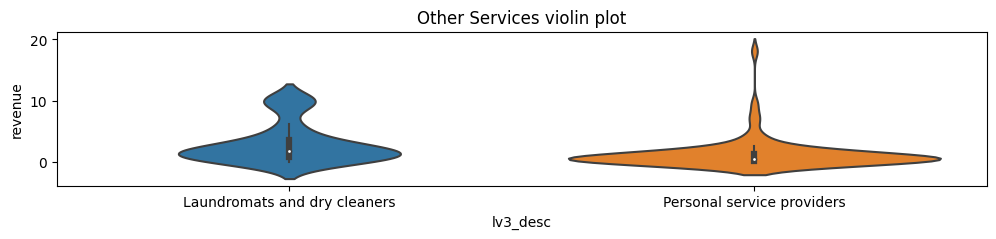

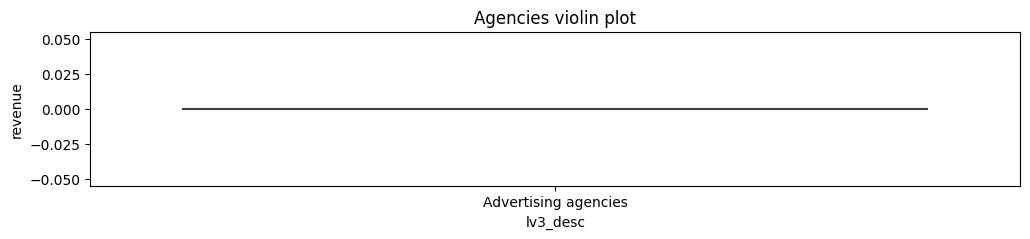

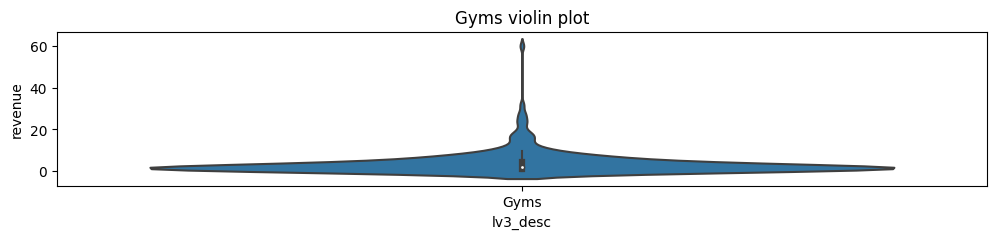

In [19]:
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

Remove-outliers-function for the relationship between store type and revenue

In [20]:
def quantile_storeType_vs_revenue(stores, lower, upper):
    for store_type in stores['plaace_hierarchy_id'].unique():
        data = stores[stores['plaace_hierarchy_id']==store_type]
        upper_treshold = data['revenue'].quantile(upper)
        lower_treshold = data['revenue'].quantile(lower)
        stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']>upper_treshold)].index, inplace=True)
        stores.drop(stores[(stores['plaace_hierarchy_id']==store_type) & (stores['revenue']<lower_treshold)].index, inplace=True)
    

In [23]:
quantile_storeType_vs_revenue(stores_train,0.05,0.86)

Plot after removing outliers

you can see in the plot below that the outliers has been removed


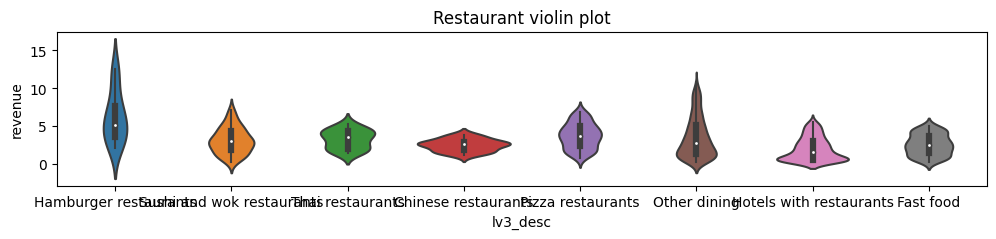

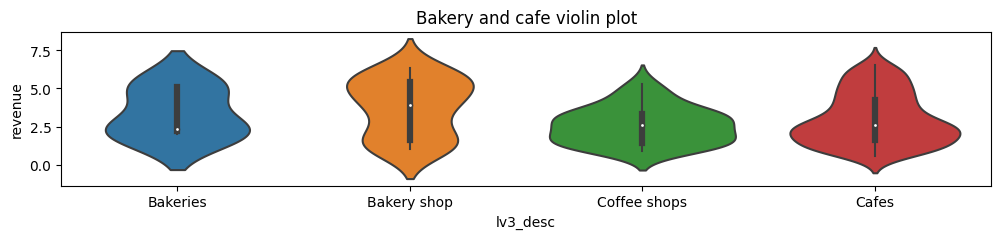

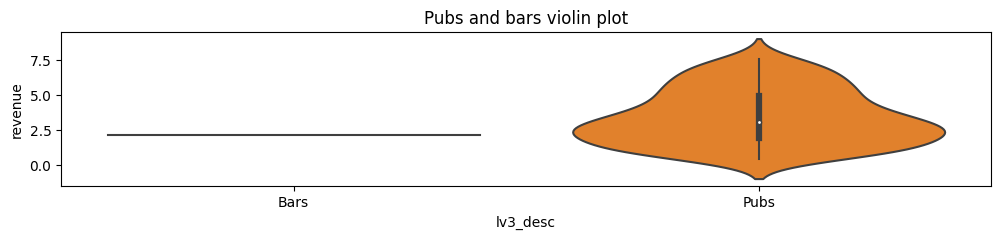

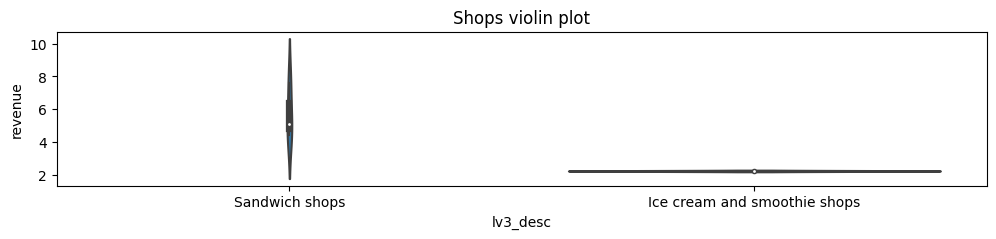

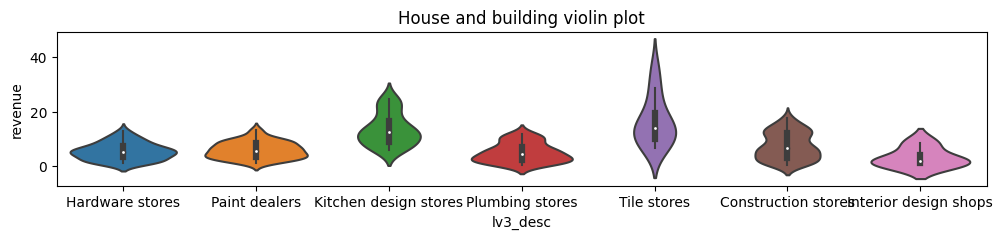

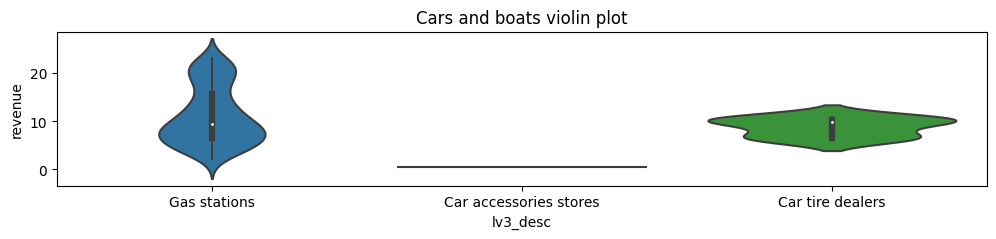

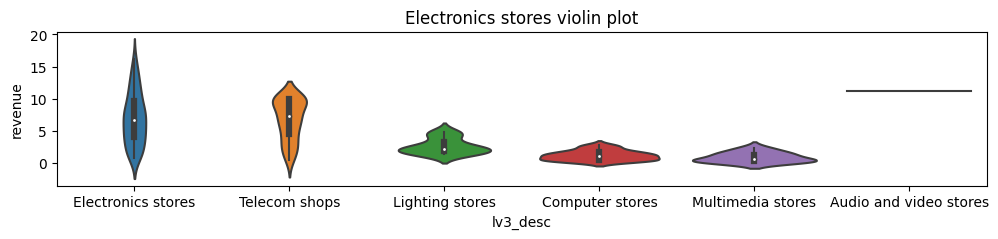

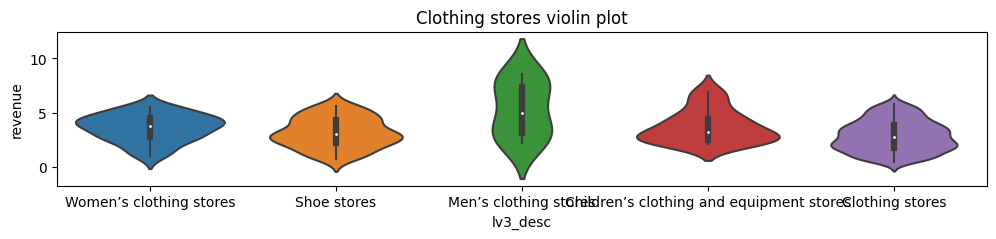

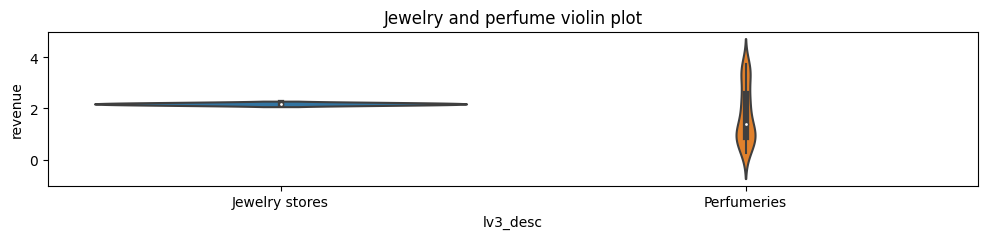

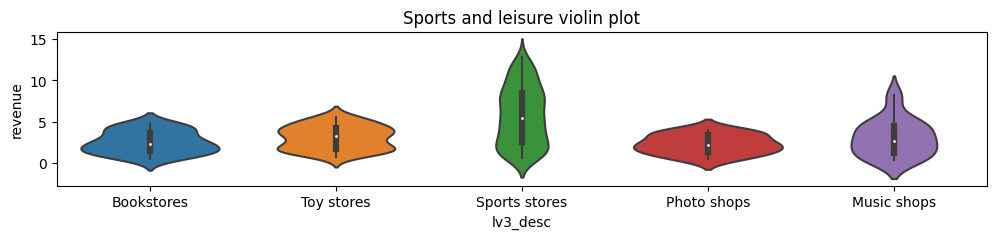

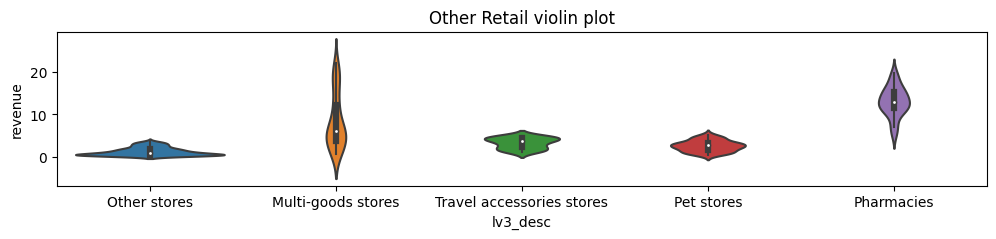

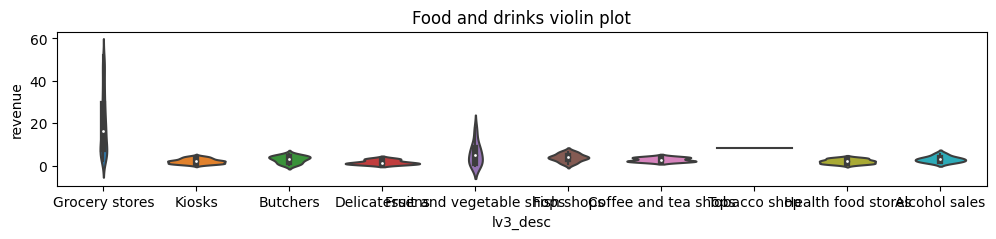

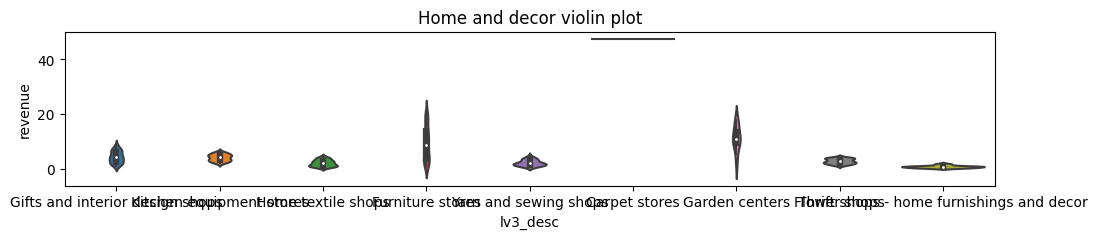

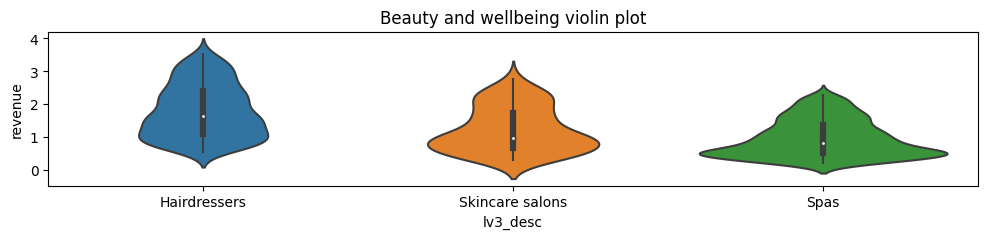

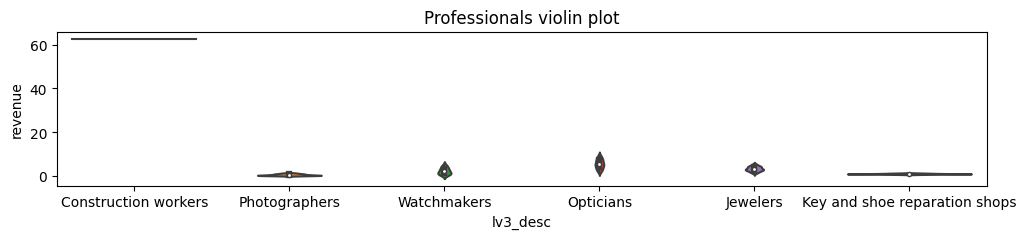

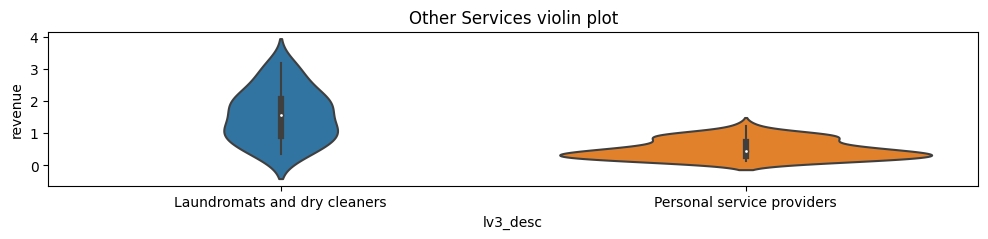

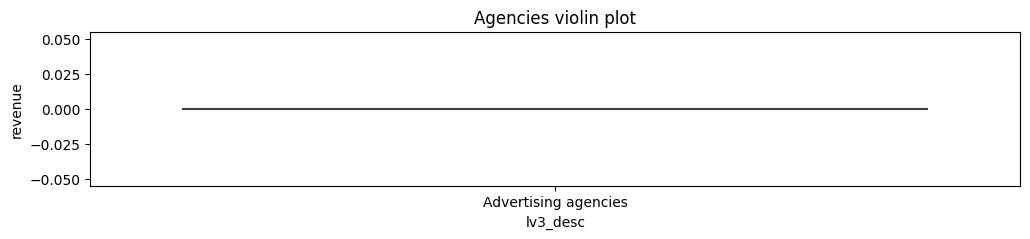

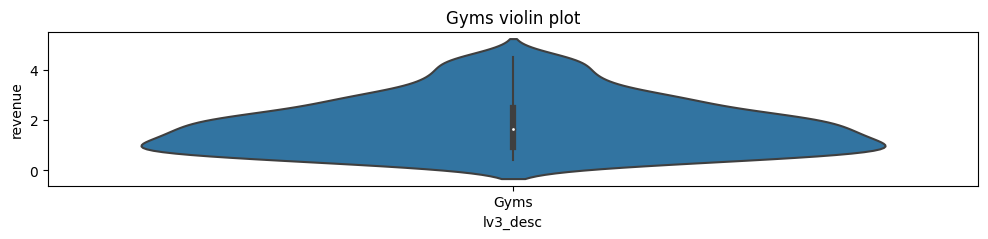

In [24]:
plaace_hierarchy = pd.read_csv('data/plaace_hierarchy.csv')
stores_with_hierarchy = stores_train.merge(plaace_hierarchy, how='left', on='plaace_hierarchy_id')
for store_type in stores_with_hierarchy['lv2_desc'].unique():
    plt.figure(figsize=(12,2))
    sns.violinplot(x='lv3_desc',y='revenue',data=stores_with_hierarchy[stores_with_hierarchy["lv2_desc"]==store_type]).set_title(f"{store_type} violin plot")
    plt.show()

#### comparing test set to training set

In [25]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

comparing coordinates

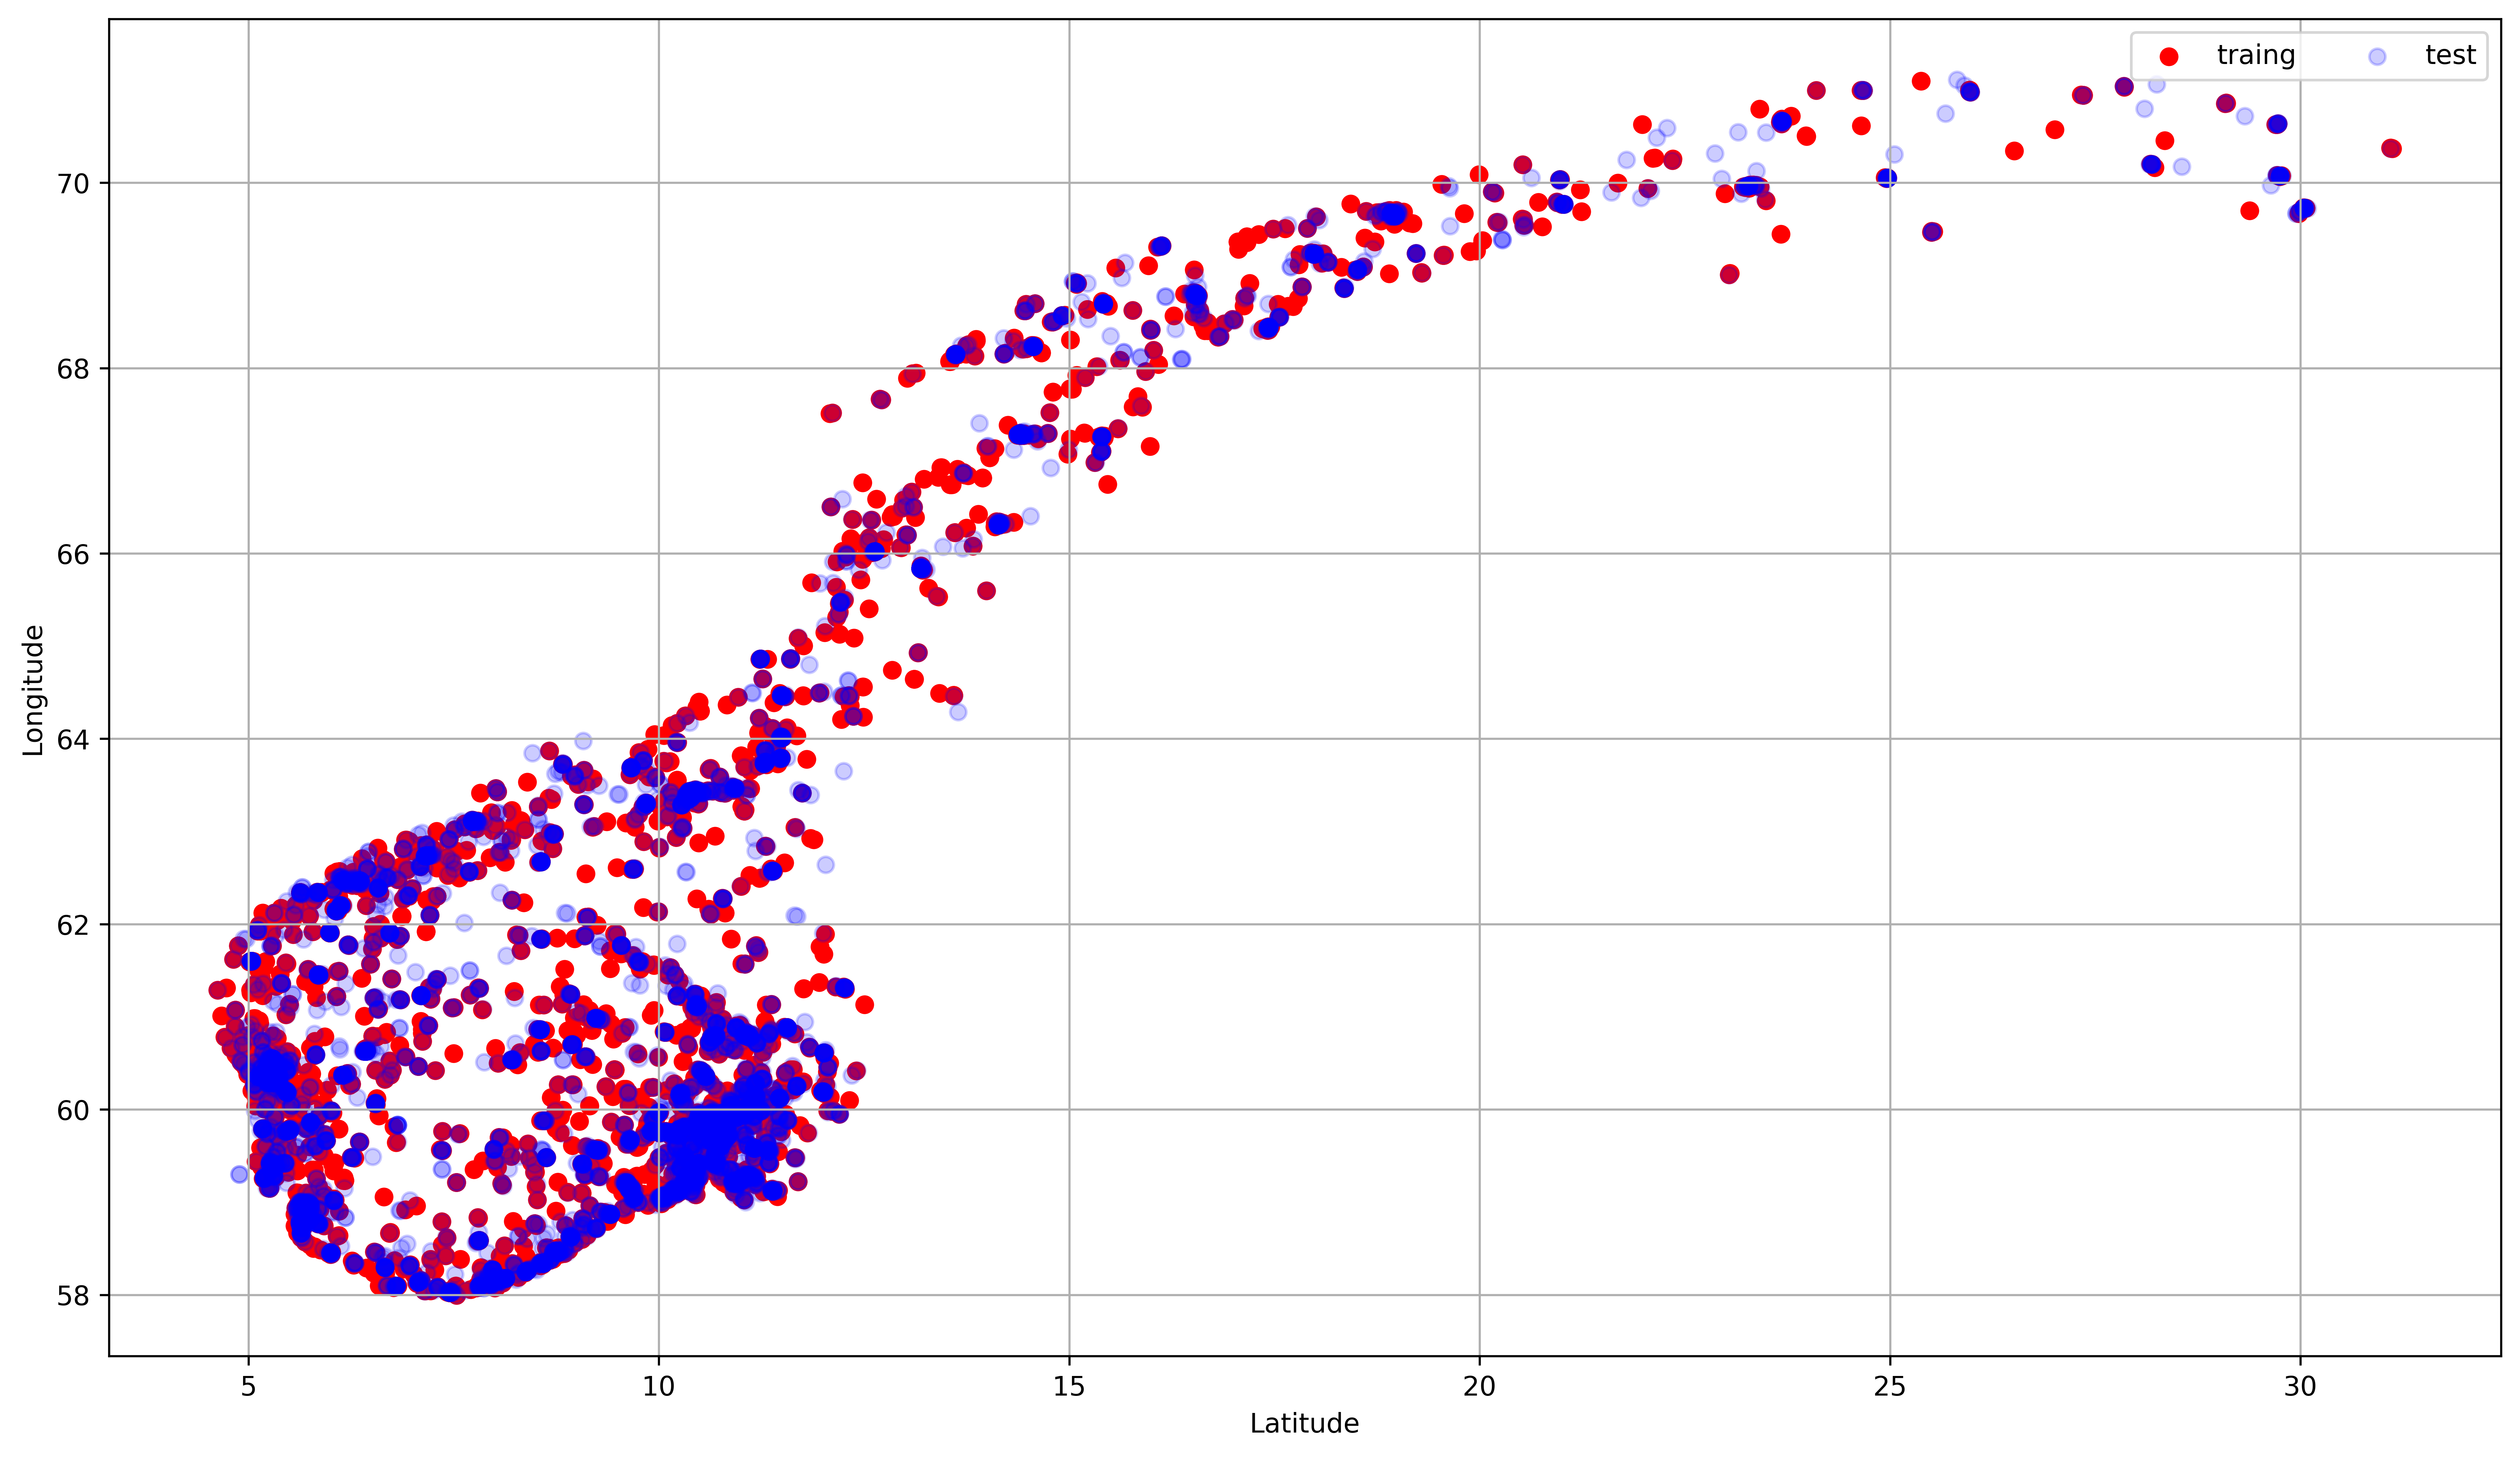

In [26]:
plt.figure(figsize=(16,9), dpi=600)
plt.scatter(stores_train['lon'],stores_train['lat'], label="traing",color='red')
plt.scatter(stores_test['lon'], stores_test['lat'], alpha=0.2, label="test", color="blue")
plt.legend(fontsize=10,ncol=2)
plt.xlabel("Latitude")
plt.ylabel("Longitude")
plt.grid()
plt.show()



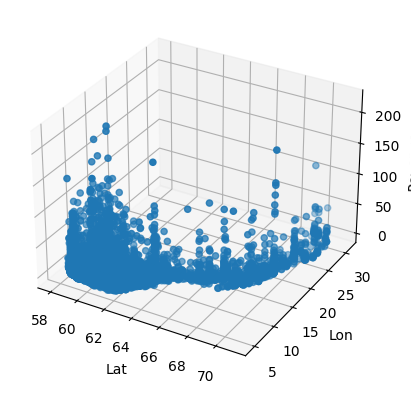

In [27]:
fig = plt.figure()
ax1 = fig.add_subplot(projection='3d')
ax1.scatter(stores_train['lat'],stores_train['lon'],stores_train['revenue'])
ax1.set_xlabel('Lat')
ax1.set_ylabel('Lon')
ax1.set_zlabel('Revenue')
plt.show()


#### Examine whether a store occurs in multiple datasets 

In [28]:
def stores_that_are_in_both_sets(df1, df2):
    
    duplicate_set = pd.merge(df1,df2, how='inner', on='store_name')
    return duplicate_set

stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
stores_extra = pd.read_csv('data/stores_extra.csv')

dup = stores_that_are_in_both_sets(stores_test, stores_train)
dup.describe()

year_x  grunnkrets_id_x      lat_x      lon_x  year_y  grunnkrets_id_y  \
count    50.0     5.000000e+01  50.000000  50.000000    50.0     5.000000e+01   
mean   2016.0     1.082298e+07  61.908053  10.342839  2016.0     9.872610e+06   
std       0.0     5.841320e+06   3.514143   3.587168     0.0     5.950003e+06   
min    2016.0     2.130304e+06  58.027347   5.323728  2016.0     1.010206e+06   
25%    2016.0     5.160203e+06  59.268041   7.860412  2016.0     4.275456e+06   
50%    2016.0     1.070035e+07  60.392696  10.407852  2016.0     1.058520e+07   
75%    2016.0     1.620020e+07  63.435578  10.885508  2016.0     1.525775e+07   
max    2016.0     1.903040e+07  69.667076  18.970989  2016.0     1.925020e+07   

           lat_y      lon_y     revenue  
count  50.000000  50.000000   50.000000  
mean   61.580750  10.216881   11.828460  
std     3.468317   3.868324   23.453886  
min    58.179772   5.190352    0.192000  
25%    59.301062   7.360328    1.910250  
50%    59.950638  10.442986    4.789000  
75%    62.650476  10.927356    9.136250  
max    69.649089  18.991212  127.436000

### explore the other data sets

In [29]:
buss_stopps = pd.read_csv('data/busstops_norway.csv')
buss_stopps.head()

busstop_id                  stopplace_type  \
0  853cb081-cc32-4880-aa3e-26e96870d874              Plattform og lomme   
1  156b052b-2771-497a-b4f4-97fed59e1aca  Lomme og skilt, ikke plattform   
2  7312a280-e14f-4b09-a421-02e8fe1bc63e                             NaN   
3  d9cda2c7-355a-49c1-b56c-a33180d2a82e                             NaN   
4  f803bcd3-182d-450b-bbb4-113c6ca885c2                             NaN   

         importance_level  side_placement  \
0  Mangler viktighetsnivå  LEFT_AND_RIGHT   
1  Mangler viktighetsnivå  LEFT_AND_RIGHT   
2  Mangler viktighetsnivå     MIDDLE_LEFT   
3  Mangler viktighetsnivå     MIDDLE_LEFT   
4  Mangler viktighetsnivå    MIDDLE_RIGHT   

                                   geometry  
0  POINT(6.54064723379766 61.0618887850553)  
1  POINT(5.89980086113255 60.1421872817075)  
2  POINT(10.7781327278563 59.9299988828761)  
3  POINT(10.7781496457324 59.9301044643692)  
4  POINT(10.7781676444854 59.9302099995898)

In [30]:
grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
grunnkrets.head()

grunnkrets_id  year     grunnkrets_name          district_name  \
0       10010701  2015      Grim-Dueknipen  Grim-Møllevann-Dalane   
1       10010803  2015  Kvadraturen sørøst         Kvadraturen-Eg   
2       10020608  2015            Ormestad                  Holum   
3       10020901  2015              Tregde        Tregde-Skjernøy   
4       10030210  2015           Bryneheia             Vanse/Åpta   

  municipality_name                                           geometry  \
0      Kristiansand  MULTIPOLYGON(((7.97199691121304 58.14336769560...   
1      Kristiansand  POLYGON((8.00234207061135 58.1443514886041, 8....   
2            Mandal  POLYGON((7.48512808482995 58.0374976883392, 7....   
3            Mandal  MULTIPOLYGON(((7.50996051810658 58.02134863868...   
4           Farsund  POLYGON((6.70396719073296 58.0877854965615, 6....   

   area_km2  
0  0.768961  
1  0.361355  
2  0.280188  
3  0.156311  
4  0.791894

#

In [31]:
gk_income = pd.read_csv('data/grunnkrets_income_households.csv')
gk_income.head()

grunnkrets_id  year  all_households  singles  couple_without_children  \
0       14200105  2016          551700   270300                        0   
1        2311202  2015          577700   311800                        0   
2        2310501  2015          668800   292500                        0   
3       14200401  2016          507000   250700                        0   
4       14200105  2015          539900   275800                        0   

   couple_with_children  other_households  single_parent_with_children  
0                     0                 0                            0  
1                682300                 0                            0  
2                842000                 0                            0  
3                     0                 0                            0  
4                710300                 0                            0

In [32]:
def add_selected_columns(dFrame):
    grunnkrets = pd.read_csv('data/grunnkrets_norway_stripped.csv')
    grunnkrets.drop(['year','geometry','area_km2','municipality_name','grunnkrets_name'], axis=1, inplace=True)
    grunnkrets.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
    
    income = pd.read_csv('data/grunnkrets_income_households.csv')
    income.drop(['year','singles','couple_with_children','other_households','single_parent_with_children','couple_without_children'],axis=1, inplace=True)
    income.drop_duplicates(subset=['grunnkrets_id'], inplace=True)
    
    concat = pd.merge(dFrame, grunnkrets, how='left', on='grunnkrets_id')
    concat = pd.merge(concat, income, how='left', on='grunnkrets_id')
    
    return concat


# 2.___________ _Machine Learning Models and Predictions_ ___________


## Louis modeller

## _____ LightGBM _____

Helper functions

In [33]:
def convert_DType_LGBM(dFrame):
    X = pd.DataFrame()
    for col_name in dFrame:
        if dFrame[col_name].dtypes == 'object':
            X[col_name] = dFrame[col_name].astype('category')
        else:
            X[col_name] = dFrame[col_name]
    
    return X


In [34]:
stores_train = pd.read_csv('data/stores_train.csv')

# select prefered columns
#remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','grunnkrets_id','address'])
remove_columns(stores_train, ['store_id','year'])

# Add features
print(stores_train.shape)
stores_train = add_selected_columns(stores_train)
print(stores_train.shape)

# Divide data into train and test set
temp_x = stores_train.drop('revenue', axis=1)
temp_y = stores_train['revenue']

_, x_test, _, y_test = train_test_split(temp_x, temp_y, test_size=0.20, random_state=1)


# Preprocess/Clean data
quantile_storeType_vs_revenue(stores_train,0.01, 0.86)
#remove_retailers_with_0_revenue(stores_train)

# Divide data into x and y train, and test data for submission
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']


# Convert from object type to numerical
x_train = convert_DType_LGBM(x_train)
x_test = convert_DType_LGBM(x_test)



(12859, 10)
(12859, 12)


In [35]:
x_test.head()

store_name plaace_hierarchy_id  sales_channel_name  \
7171           ELITE MAT AS             2.8.1.0      Grocery stores   
5164  MAXELLE AMFI ÅKREHAMN             2.4.6.0     Clothing stores   
3158  JERNVARE DRANGEDAL AS             2.1.1.0      Hardware store   
4234       ELKJØP  KIRKENES             2.3.1.0  Electronics stores   
4566     SKOTØYMAGASINET AS             2.4.2.0         Shoe stores   

      grunnkrets_id            address        lat        lon    chain_name  \
7171        6020606      TOLLBUGATA 30  59.737597  10.207078           NaN   
5164       11490301                NaN  59.264405   5.192721           NaN   
3158        8170207  TØRDALSVEIEN 25 A  59.096753   9.053424           NaN   
4234       20300301       VERKSVEIEN 1  69.720500  30.038844  ELKJØP NORGE   
4566       20190107       STORGATA 7 C  70.981458  25.974303           NaN   

          mall_name district_name  all_households  
7171            NaN       Strømsø        383000.0  
5164  Amfi Åkrehamn          Åkra        490200.0  
3158            NaN     Drangedal        429300.0  
4234            NaN      Kirkenes        459500.0  
4566            NaN      Nordkapp        438200.0

Make model and train

In [36]:
# tune params
parameters = {
              #'metric': 'acc',
              #'n_estimators' : 400
              'path_smooth' : 0.5,
              'min_data_in_leaf' : 3
             }
# Model
LGBM = LGBMRegressor()
#LGBM =LGBMRegressor(reg_alpha=1.5570962138350035e-05, reg_lambda=5.304314352196518e-06,n_estimators=253)
# fitting
LGBM.fit(x_train, y_train)


LGBMRegressor()

Test LightGBM

In [37]:
# predicting the test split
pred = LGBM.predict(x_test)
number_of_negatives = 0
for i in range(len(pred)):
    if pred[i] < 0.0:
        number_of_negatives += 1
        pred[i] = 0.0
print(f"number of negatives: {number_of_negatives}")
print(f"rmsle: {rmsle(y_test,pred)}")

number of negatives: 4
rmsle: 0.7186989326991395


In [38]:
# Previous rmse scores gave the following kaggle scores:
# - 0.74281469137304 rmsle resulted in: 0.75490 on kaggle - without hyperparameter tuning
# - 0.723009869045512 rmsle resulted in: 0.76138 on kaggle - with hyperparameter tuning => overfitted? used non categorical datatype, significantly redused performance
# - 0.7253602035043905 rmsle resulted in 0.75625 in kaggle - no hyperparameter tuning, include all attributes

Predict test and submit

In [39]:
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')
test = stores_test.copy()

# Select columns/features
remove_columns(stores_train, ['store_id','year'])
remove_columns(test, ['store_id','year'])
print(test.shape)
stores_train = add_selected_columns(stores_train)
test = add_selected_columns(test)
print(test.shape)

# Preprocess/Clean data
quantile_storeType_vs_revenue(stores_train,0.01, 0.86)
#remove_retailers_with_0_revenue(stores_train)

# Divide data into x and y train, and test data for submission
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']

# Convert from object type to numerical
x_train = convert_DType_LGBM(x_train)
test = convert_DType_LGBM(test)

# Model and fitting
LGBM =LGBMRegressor(**parameters)
LGBM.fit(x_train, y_train)

# Predict test-data-set
pred_test_LGBM = LGBM.predict(test)

# remove negative values
number_of_negatives = 0
for i in range(len(pred_test_LGBM)):
    if pred_test_LGBM[i] < 0.0:
        number_of_negatives += 1
        pred_test_LGBM[i] = 0.0
print(number_of_negatives)


(8577, 9)
(8577, 11)
[LightGBM] [Warning] min_data_in_leaf is set=3, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=3
23


In [40]:

print(test.shape)
test.head()

(8577, 11)


store_name plaace_hierarchy_id     sales_channel_name  \
0  VÅLERENGA HALAL BURGER AS             1.1.1.0  Hamburger restaurants   
1          BURGER KING MYREN             1.1.1.0  Hamburger restaurants   
2        BURGER KING STOVNER             1.1.1.0  Hamburger restaurants   
3    BURGER KING TUNGASLETTA             1.1.1.0  Hamburger restaurants   
4           VULKAN BURGERBAR             1.1.1.0  Hamburger restaurants   

   grunnkrets_id                 address        lat        lon  \
0        3012704        STRØMSVEIEN 25 A  59.908672  10.787031   
1        8061401                 MYREN 1  59.201467   9.588243   
2        3013917        STOVNER SENTER 3  59.962146  10.924524   
3       16012104          TUNGASLETTA 16  63.420785  10.461091   
4        3014305  AUD SCHØNEMANNS VEI 15  59.921102  10.785123   

         chain_name       mall_name district_name  all_households  
0               NaN             NaN     Vålerenga        386900.0  
1       BURGER KING             NaN        Gulset        470200.0  
2       BURGER KING  Stovner Senter        Fossum        444100.0  
3       BURGER KING             NaN    Strindheim        494800.0  
4  VULKAN BURGERBAR             NaN         Hasle        474000.0

In [41]:
#write the predicition to file
writeResultToFile(stores_test, pred_test_LGBM, "LGBM_01_86_precentile_allCols_districtName_allHouseHolds_someSmoothin")

# Verify format of submission file
submissionVery = pd.read_csv('submissionFiles/LGBM_01_86_precentile_allCols_districtName_allHouseHolds_someSmoothin.csv')
submissionVery.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8577 entries, 0 to 8576
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   id         8577 non-null   object 
 1   predicted  8577 non-null   float64
dtypes: float64(1), object(1)
memory usage: 134.1+ KB


## _____ Random Forest Regressor _____

Load, preprocess and convert data to correct format

In [42]:
# Load training and test data
stores_train = pd.read_csv('data/stores_train.csv')
stores_test = pd.read_csv('data/stores_test.csv')

# Preprocess/Clean data
remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
remove_columns(stores_test, ['store_id','year','store_name','sales_channel_name','address','chain_name','mall_name'])
#remove_retailers_with_0_revenue(stores_train)
quantile_storeType_vs_revenue(stores_train,0.10, 0.80)

# Divide data into x and y train
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
x_test = stores_test.copy()

# Convert from object type to numerical
#train set
cat_columns = x_train.select_dtypes(['object']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])
#test set
cat_columns = x_test.select_dtypes(['object']).columns
x_test[cat_columns] = x_test[cat_columns].apply(lambda x: pd.factorize(x)[0])



In [43]:
stores_train.head()

plaace_hierarchy_id  grunnkrets_id        lat        lon  revenue
2             1.1.1.0        6050102  60.164751  10.254656   16.099
3             1.1.1.0       18040102  67.283669  14.379796    9.296
4             1.1.1.0       16017414  63.358068  10.374832    4.528
5             1.1.1.0       11030509  58.970249   5.731728   12.020
6             1.1.1.0       18050706  68.438025  17.422916    7.622

Train model

In [44]:
# Model
RFR = RandomForestRegressor(n_estimators=100)

# Fitting
RFR.fit(x_train, y_train)


RandomForestRegressor()

Test RFR model

In [45]:
# predicting the training data set as a pin pointer
pred_train_RFR = RFR.predict(x_train)
print(rmsle(y_train, pred_train_RFR))
print(RFR.score(x_train, y_train))

0.24634482634264826
0.9217547273453869


Predict test and submit

In [46]:
pred_test_RFR = RFR.predict(x_test)

In [48]:
# Write to file
#writeResultToFile(stores_test, pred_test_RFR, "RFR_10_80_percentile")

# Verify format of submission file
#submissionVery = pd.read_csv('submissionFiles/RFR_10_80_percentile.csv')
#submissionVery.info()

## Emil modeller

### model 1


In [49]:
# pythons stuff emil

# 3. Feature Engineering

### some feature moding

In [50]:
#modding data....

# 4. Model Interpretations

In [51]:
# fetch train  set
stores_train = pd.read_csv('data/stores_train.csv')
#remove_columns(stores_train, ['store_id','year','store_name','sales_channel_name','grunnkrets_id','address'])
remove_columns(stores_train, ['store_id','year'])
quantile_storeType_vs_revenue(stores_train,0.02, 0.86)
x_train = stores_train.drop('revenue', axis=1)
y_train = stores_train['revenue']
cat_columns = x_train.select_dtypes(['object']).columns
x_train[cat_columns] = x_train[cat_columns].apply(lambda x: pd.factorize(x)[0])


learning_rate                    : 0.02
num_leaves                       : 218
colsample_bytree                 : 0.954740547331804
subsample                        : 0.9460284080752744
verbosity                        : -1
random_state                     : 42
objective                        : regression
metric                           : l2
num_threads                      : 6
reg_alpha                        : 0.008636569439929256
min_sum_hessian_in_leaf          : 0.0705069745494239
reg_lambda                       : 1.4078036808471034e-07
n_estimators                     : 157


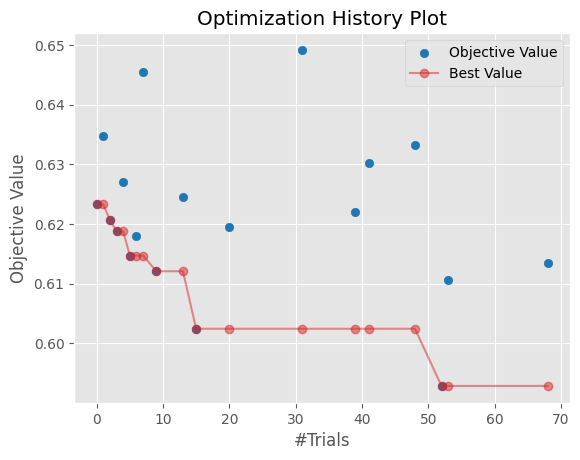

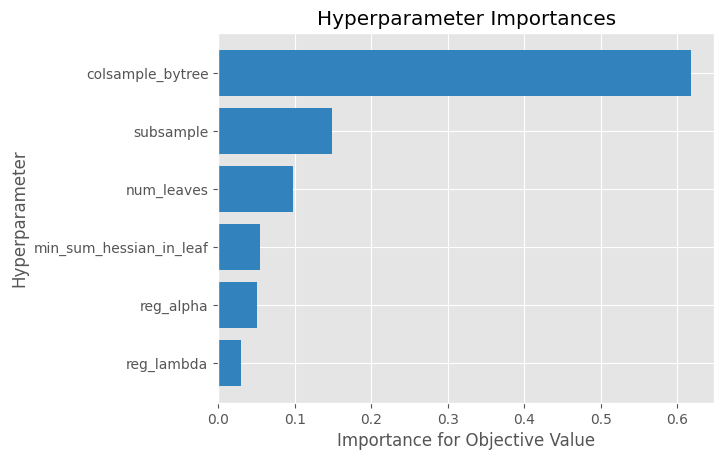

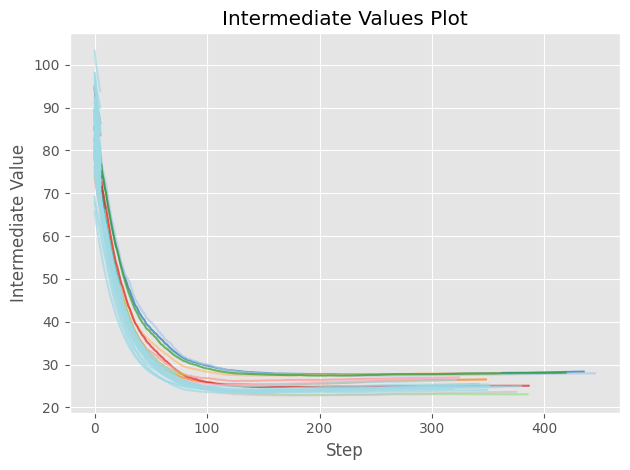

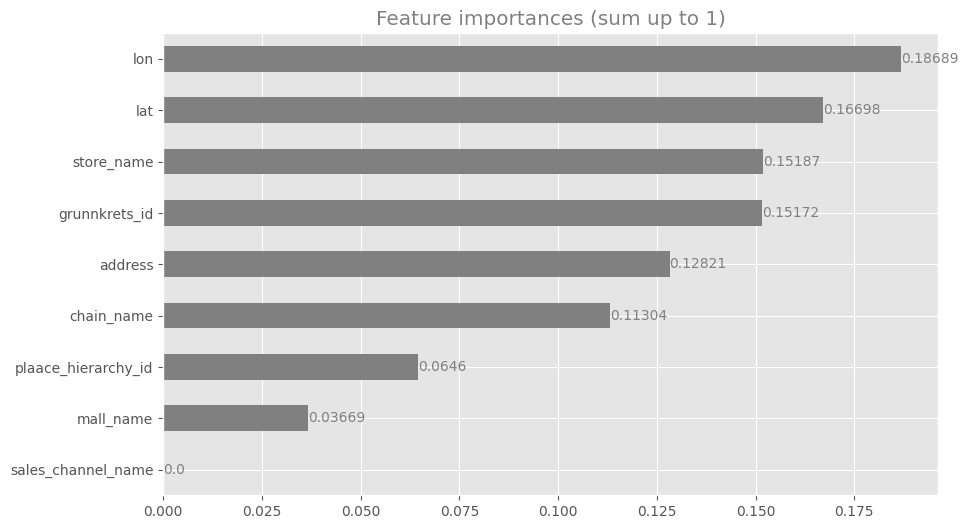



Time elapsed for fit execution: 1 min 29.143 sec


In [52]:

# Tune
tuner = LGBMTuner(metric = 'rmsle', verbosity=0)
tuner.fit(x_train, y_train)



### Lime

In [53]:
#lime stuff in python

### Feature importance

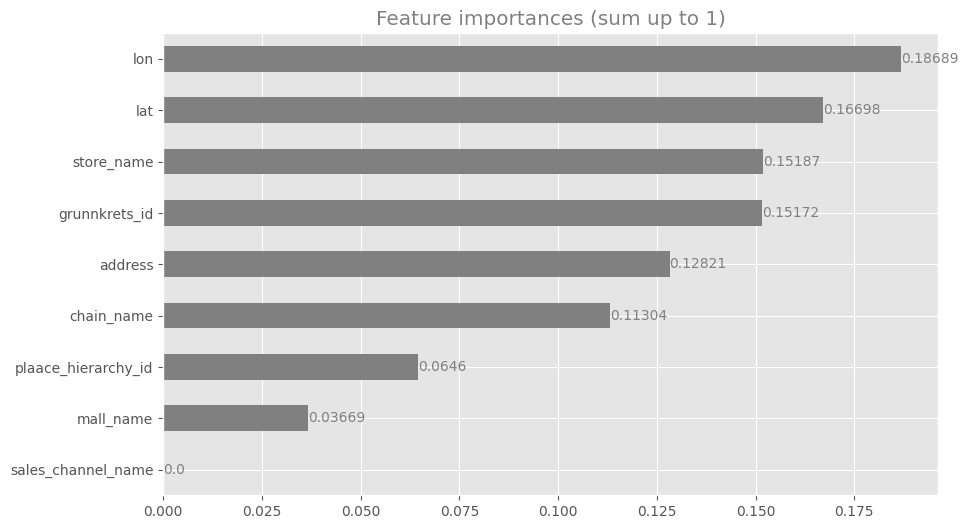

In [54]:
#feature importance

tuner.plot_importances()


### PDP

In [55]:
#PDP

# 5. Final improved models/predictions

### model 1

In [56]:
#final model 1

### model 2

In [57]:
#final model 2

# Testing


#### RMSLE

In [58]:
def rmsle(y_true, y_pred):
    return metrics.mean_squared_log_error(y_true, y_pred)**0.5
